# Running BlueFog with jupyter notebook

The **goal** of this ipython notebook is to show you how you can run BlueFog code in ipython notebook environment.

As you know, the BlueFog framework is aimed to run decentralized algorithm over a cluster of processes or machines.
Meanwhile, jupyter notebook is an execellent interactive frontend talking with single IPython process. This contradictory of single process and cluster can be completely circumvented, fortunately. The main idea is using the jupyter notebook as the controller to inform how the cluster will execute the BlueFog code. On one hand, the execution of BlueFog is still running over multiple processes so that you can enjoy the scalability and parallelism brought by BlueFog. On the other hand, you (the programmer) can interactively execute with BlueFog and monitor and control the code in the single place.

## Prerequisites: 
To begin with, make sure that you have installed OpenMPI and BlueFog in your system first.
Besides these, you also need to install [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/index.html) package for managering the parallel computation.
Usually, you can install it through `pip install jupyter ipyparallel`.

## Steps to run Bluefog with Jupyter Notebook

- **Step 1: Start jupyter notebook**

```shell
jupyter notebook
```

- **Step 2A: Start the `ibfrun` (interactive bluefog run) in single machine**

```shell
ibfrun -np 4 start
```
where `np` means the number of process. In this example command, it will start 4 processes. You are free to choose any number between 1 and the number of CPU processes in you machine. 

- **Step 2B: Start the `ibfrun` in multiple machines**

```shell
ibfrun -np 16 -H machine1:4,machine2:4,machine3:4,machine4:4 start
```
where `machine1` to `machine4` are the machine name or the address of the machine and `:4` after the machine name means on that machine launch 4 processes. Before you run this command, please make sure that all the machines is able to be login through `ssh` **without** typing the password.

That's it!

**Other remakrs**
- Please make sure the starting jupyter notebook command and the ibfrun command are under the same machine.
- If you want to communicate over GPUs through NCCL, the number of process in each machine should not exceed the number GPUs instead of CPUs.



In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# Connect the Jupyter Notebook to the Cluster (workers)

The first step is to let the jupyter notebook connect to cluster. To achieve that, import the ipypyarallel library since we rely on it to manager the cluster, then connect it through `ipp.Client(profile="bluefog")` as shown in the following cell.

`rc` (remote client) is the key that you will use to send the code from this notebook (driver) to the cluster namely multiple workers. 
To check the notebook has connected to the worker succesfully, you can look the ID of remote clients through `rc.ids`
Depending on how many processes you starts, the length of rc will be the same number as the number of process you start the `ibfrun`, i.e. the number after `-np`.

In [2]:
import ipyparallel as ipp
rc = ipp.Client(profile="bluefog")
rc.ids

[0, 1, 2, 3]

If you saw the `ids` is an empty list, this means ipyparallel cannot connect it with the clusters. You can stop the `ibfrun` by `ctrl+c`. Kill all remainning `ipcontroller` or `mpi` processes through `ps` if necessary. Then, try to rerun the `ibfrun` again.

#  Parallel execution through `px`

`px` -- parallel execution is a [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) in IPython environment similar as the `%matplotlib` or `%%timeit`. If you are not familar with magic command, you can think it as a special command in IPython that will change the behavior of IPython to interprete the following python code. As the same for all magic commands, `%px` is for one line and `%%px` is for whole cell. For example 
`%px print("Hello world")` will put the `print("Hello world")` to run under the `px` environment. And, if you put the `%%px` at the top of one cell, the rest code in that cell all will be run under the `px` environment.

The code under the `px` env will be executed into all each worker in parallel instead of running in this notebook.
It is important to rememebr that each worker are one seperated IPython environment as well. The following is hello-world example to work with bluefog in jupyter notebook, which is already sufficient for most  usage cases. You can find more advanced usage of `px` in the [document page](https://ipyparallel.readthedocs.io/en/latest/magics.html).


In [3]:
%%px
import bluefog.torch as bf

bf.init()
message = f"Hello, I am {bf.rank()} among {bf.size()} processes"
print(message)

[stdout:0] Hello, I am 2 among 4 processes
[stdout:1] Hello, I am 3 among 4 processes
[stdout:2] Hello, I am 0 among 4 processes
[stdout:3] Hello, I am 1 among 4 processes


You should see `Hello, I am {x} among {np} processes` repeated np time where `x` ranges from 0 to np-1. This `x` is called rank. Note the code is the same while the output is different. This is the typical usage of BlueFog code, which belong to the Single Instruction, Mutliple Data [SIMD](https://en.wikipedia.org/wiki/SIMD) pattern. Hence, `bf.rank()` is the key identity for the coding.

# Moving the data between workers and driver

Only executing the BlueFog code in multiple worker through notebook is not interesting enough. Because all running results only remains in the worker. The notebook do not know those results by default. You can try to run `print(message)` in the cell without `px`, you will encouter the not define error.

Fortunately, we can easily extract or pass the data and object between workers and driver.
The key componenet is Direct View class through `dview=rc[:]`. Using `dview.push()` and `dview.pull()`, it transmits the data between workers and driver.

In [4]:
%%px
import torch
x = torch.FloatTensor([bf.rank()])

Now all workers have the tensor `x` that only contains the 1x1 value equals their rank.

In [5]:
dview = rc[:] # A DirectView of all engines
dview.block=True
x_at_rank0 = dview.pull('x', targets=0)
x_at_rank0

tensor([2.])

What above the code did is that notebook pull the value `x` of worker 0. Note the worker 0 may not be the worker has rank 0. Hence, the value may not be zero. You also pull the results of all works or so partial.

In [6]:
xs_at_1_and_2 = dview.pull('x', targets=[1, 2])
xs_at_1_and_2

[tensor([3.]), tensor([0.])]

In [7]:
xs_all = dview.pull('x')
xs_all

[tensor([2.]), tensor([3.]), tensor([0.]), tensor([1.])]

You can also push the data from the notebook to all works through `dview.push(arg)`, of which the argument is a dictionary that map from the variable name to variable value.

In [8]:
# Push the data into all workers
dview.push({'seed': 12345})

[None, None, None, None]

In [9]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  12345
[stdout:1] I received seed as value:  12345
[stdout:2] I received seed as value:  12345
[stdout:3] I received seed as value:  12345


# A simple average-consensus example

Now, with px magic command and direct-view, we are good to run and plot a simple average-consensus example.

In [10]:
%%px

# It is import to give different random seed to different workers.
torch.random.manual_seed(seed * bf.rank() + bf.rank())

data_size = 10
max_iters = 100

In [11]:
%%px
import bluefog.common.topology_util as topology_util

# Set exponential-2 graph as topology, which is default actaully.
assert bf.set_topology(topology_util.ExponentialTwoGraph(bf.size()))

# Create a random data to run consensus
x = torch.randn(data_size, dtype=torch.double)

# Use allreduce to find the truth of average for reference
x_bar = bf.allreduce(x, average=True)

mse = []
for ite in range(max_iters):
    # The following code is equivalent to:
    #  x_i = \sum_{j\in Neighbor(i)} a_ij x_j
    # where a_ij is entry of the combination matrix 
    # that definied through the set_topology command.
    x = bf.neighbor_allreduce(x, name='x')
    mse.append(torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2))

In [12]:
mse_0 = dview.pull('mse', block=True, targets=0)

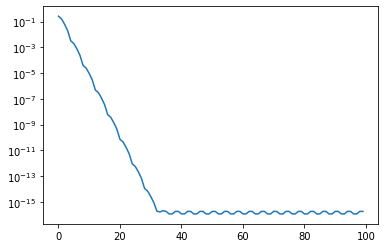

In [13]:
plt.semilogy(mse_0)

You can also plot the multiple figures from multiple works by adding `--targets 1:3` after `px`. In this case, worker 1 and worker 2 will plot the figures.

[output:1]

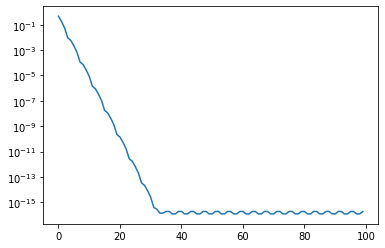

[output:2]

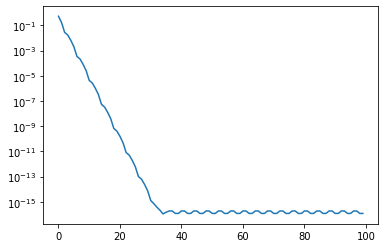

In [14]:
%%px  --targets 1:3
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogy(mse)
plt.show()

# What happens after you run `ibfrun`

If you are curious about what happened after running the ibfrun, the following figure should give you a good overview.

<img src="./images/ibfrun.png" alt="ibfrun" width="780"/>

When you start the jupyter notebook, you will create a IPython client, which will keep recieving and executing the command from the notebook. `ibfrun` will create a controller and bunch of workers (it is just IPython Kernel actually) under the MPI environment. The controller knows how to communicate with the IPython client and the workers. When you execute the code under `px` environment, what happens:

1. Send code back to the IPython client
2. The IPython client notices this code is need to be run under `px` so it forward the code to the controller.
3. The controller forward the code to the worker according the targets. By default, it will forward to all workers.
4. The workers accept the command and execute it in parallel. If there is data exchange between the processes, it will communicate through the MPI.
5. When all workers finished the executing the code, it will reverse the path to tell the jupyter noteboo that execute is done.


As for the push and pull command in direct view, it is similar as the `px` data flow.

Last, notice that `ibfrun` is just a thin wrapper for convenience over the command provided by the `ipyparallel`. If you have some speical requirement or you have problem of executing `ibfrun`, you can use the `ipcontroller` or `ipengin` command directly. Check [ipyparallel document](https://ipyparallel.readthedocs.io/en/latest/process.html) for more details.

## Suspend BlueFog
Bluefog will launch a background process, which may consume lots of your CPU usage
even if you don't use it actively. You can suspend it through `bf.suspend()`.
Note after it is suspended, you no longer are able to run BlueFog communication function.
You can continue the usage through `bf.resume()` again.

In [15]:
%%px
bf.suspend()

In [16]:
%%px
bf.resume()